<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [2]:
import numpy as np
import os

# Define the folder path
folder_path = r"G:\CODING\py\data\numpy\mel\concatenatedspectrograms"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

In [3]:
eeg_fold_1.shape

(1269, 224, 224, 3)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [4]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [5]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [23]:
debug_mode_flag = False
import torch
import torch.nn as nn

class CustomCnn(nn.Module):
    def __init__(self, debug_mode_flag=False):
        super().__init__()
        self.debug_mode_flag = debug_mode_flag
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Further reduces spatial size
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Further reduces spatial size
        )
        
        # Global Average Pooling to reduce spatial dimensions 
        self.global_avg_pool = nn.AdaptiveAvgPool2d((8, 8))  # Keeps a manageable seq_len
        self.flatten = nn.Flatten(start_dim=2)  # Keeps batch & channel dims

    def forward(self, x):
        if self.debug_mode_flag: print(f"Input shape: {x.shape}")
        
        x = self.block_1(x)
        if self.debug_mode_flag: print(f"Block 1 shape: {x.shape}")
        
        x = self.block_2(x)
        if self.debug_mode_flag: print(f"Block 2 shape: {x.shape}")
        
        x = self.block_3(x)
        if self.debug_mode_flag: print(f"Block 3 shape: {x.shape}")
        
        x = self.global_avg_pool(x)  # (batch, 128, 8, 8)
        if self.debug_mode_flag: print(f"Global Avg Pool shape: {x.shape}")

        # x = self.flatten(x)  # (batch, 128, 64)
        # if self.debug_mode_flag: print(f"Flattened shape (Transformer Input): {x.shape}")
        
        return x

    
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        attn_output, _ = self.att(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TRANS_CNN(nn.Module):
    def __init__(self, input_shape, num_classes, embed_dim=512, num_heads=2, ff_dim=64, num_transformer_blocks=4):
        
        super(TRANS_CNN,self).__init__()
        
        self.num_transformer_blocks = num_transformer_blocks
        self.cnn_extractor = CustomCnn()
        
        self.projection = nn.Linear(512, embed_dim)
        
        self.encoder = nn.ModuleList([
            TransformerEncoder(embed_dim,num_heads,ff_dim) for _ in range(num_transformer_blocks)
        ])
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.1)
        
        self.precls = nn.Linear(embed_dim,embed_dim)
        self.precls2 = nn.Linear(embed_dim,embed_dim)
        self.precls3 = nn.Linear(embed_dim,embed_dim//4)
        
        self.clf = nn.Linear(embed_dim//4,num_classes)
        
        
    def forward(self,x):
        
        x = self.cnn_extractor(x)
        if debug_mode_flag: print(f"x shape after cnn extraction = {x.shape}")
        
        B,C,H,W = x.shape
        
        x = x.view(B,H*W,C)
        if debug_mode_flag: print(f"x shape after changing view= {x.shape}")
        
        # x = self.projection(x)
        # if debug_mode_flag: print(f"x shape after projection= {x.shape}")
        
        for encoderblock in self.encoder:
            x = encoderblock(x)
            
        if debug_mode_flag: print(f"x shape after passing thru encoder= {x.shape}")
        
        x = x.permute(1,0,2)
        if debug_mode_flag: print(f"x shape after permuting{x.shape}")
        
        x = self.precls3(x)
        if debug_mode_flag: print(f"precls3 {x.shape}")
        
        x = self.dropout(x)
        
        x = x.mean(dim=0)  # Global average pooling over sequence (9 tokens → 1 token)
        if debug_mode_flag: print(f"x shape after average pooling {x.shape}")

        x = self.clf(x)  #they see me rolling
        if debug_mode_flag: print(f"cls {x.shape}")
        
        
        return x

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [24]:
model  = TRANS_CNN(input_shape=(224,224,3),num_classes=3,num_transformer_blocks=4,embed_dim=512) # declare model here
randomdata = torch.randn((1,3,224,224))
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [25]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
TRANS_CNN                                                    --
├─CustomCnn: 1-1                                             --
│    └─Sequential: 2-1                                       --
│    │    └─Conv2d: 3-1                                      448
│    │    └─BatchNorm2d: 3-2                                 32
│    │    └─ReLU: 3-3                                        --
│    │    └─Conv2d: 3-4                                      4,640
│    │    └─BatchNorm2d: 3-5                                 64
│    │    └─ReLU: 3-6                                        --
│    │    └─MaxPool2d: 3-7                                   --
│    └─Sequential: 2-2                                       --
│    │    └─Conv2d: 3-8                                      18,496
│    │    └─BatchNorm2d: 3-9                                 128
│    │    └─ReLU: 3-10                                       --
│    │    └─Conv2d: 3-11  

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

In [26]:
import pandas as pd
import os
import datetime


# Fold indices and other configurations
num_folds = 5
fold_indices = np.random.permutation(np.arange(num_folds))
val_fold_indices = np.roll(fold_indices, 1)

test_folds_chosen = []
val_folds_chosen = []
fold_confusion_matrices = []  # To store confusion matrices for each fold
fold_accuracies = []  # To store balanced accuracy for each fold
fold_auprcs = []  # To store AUPRC for each fold

# Model and training configurations
num_classes = 3
learning_rate = 0.0001
epochs = 100
input_shape = (3,224,224)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [27]:
def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, csv_path=r"G:\CODING\py\newnotebooks\results.csv"):
    """
    Save all results from the current experiment to a CSV file
    
    Parameters:
    - fold_accuracies: list of balanced accuracy scores for each fold
    - fold_auprcs: list of AUPRC scores for each fold
    - fold_confusion_matrices: list of confusion matrices for each fold
    - model_info: string with model architecture description
    - csv_path: path to the CSV file to save results
    """
    # Current time for experiment identification
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Prepare data for the DataFrame
    data = {
        "timestamp": timestamp,
        "model_info": model_info,
        "num_classes": num_classes,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "mean_balanced_accuracy": np.mean(fold_accuracies),
        "std_balanced_accuracy": np.std(fold_accuracies),
        "mean_auprc": np.mean(fold_auprcs),
        "std_auprc": np.std(fold_auprcs),
    }
    
    # Add individual fold results
    for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
        data[f"fold_{i+1}_accuracy"] = acc
        data[f"fold_{i+1}_auprc"] = auprc
    
    # Add confusion matrix info
    for i, cm in enumerate(fold_confusion_matrices):
        data[f"fold_{i+1}_confusion_matrix"] = str(cm)
    
    # Create DataFrame and append to CSV
    df = pd.DataFrame([data])
    
    # Check if file exists
    file_exists = os.path.isfile(csv_path)
    
    # Save to CSV
    if file_exists:
        df.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_path, mode='w', header=True, index=False)
    
    print(f"Results saved to {csv_path}")

Fold No: 1
Epoch [1/100], Loss: 1.1041, Accuracy: 0.3315
Validation Loss: 1.0848, Validation Accuracy: 0.3285
Epoch [2/100], Loss: 1.0896, Accuracy: 0.4076
Validation Loss: 1.1341, Validation Accuracy: 0.3217
Epoch [3/100], Loss: 1.0775, Accuracy: 0.3859
Validation Loss: 1.1564, Validation Accuracy: 0.2902
Epoch [4/100], Loss: 1.0662, Accuracy: 0.4728
Validation Loss: 1.0929, Validation Accuracy: 0.3243
Epoch [5/100], Loss: 1.0590, Accuracy: 0.4946
Validation Loss: 1.0442, Validation Accuracy: 0.3566
Epoch [6/100], Loss: 1.0403, Accuracy: 0.5236
Validation Loss: 1.1237, Validation Accuracy: 0.3630
Epoch [7/100], Loss: 1.0364, Accuracy: 0.5199
Validation Loss: 1.1517, Validation Accuracy: 0.3743
Epoch [8/100], Loss: 1.0277, Accuracy: 0.5290
Validation Loss: 1.0340, Validation Accuracy: 0.3868
Epoch [9/100], Loss: 1.0073, Accuracy: 0.5543
Validation Loss: 1.0631, Validation Accuracy: 0.4092
Epoch [10/100], Loss: 0.9996, Accuracy: 0.6123
Validation Loss: 1.0018, Validation Accuracy: 0.421

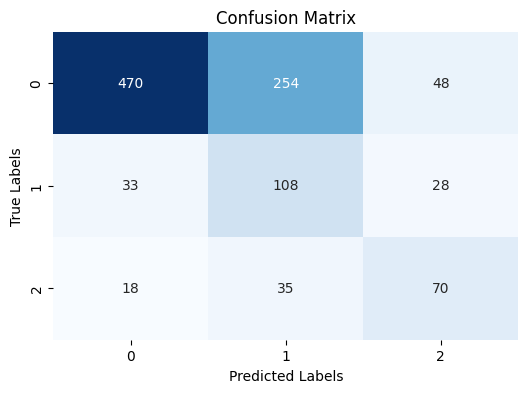


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 470/772 (60.88%)
Class 1: Correct Predictions / Total True Samples = 108/169 (63.91%)
Class 2: Correct Predictions / Total True Samples = 70/123 (56.91%)

Precision-Recall Curves:


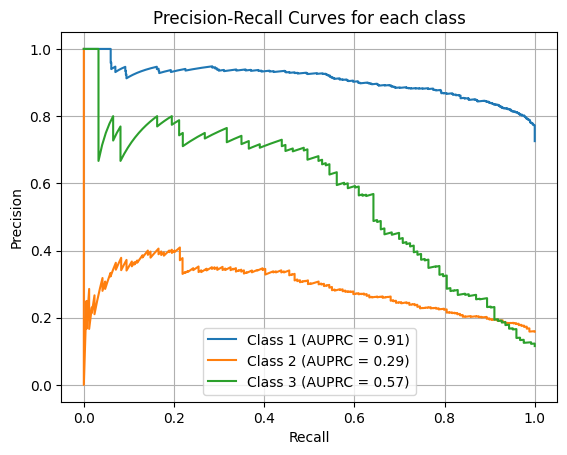


ROC Curves:


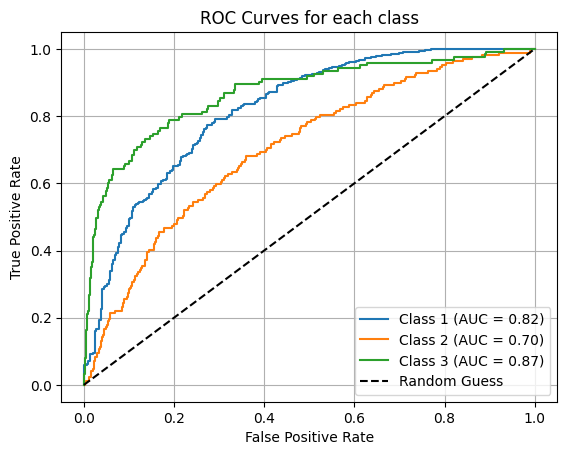


Mean F1 Score: 0.5430
Balanced Accuracy: 0.6057
Average AUPRC: 0.5890

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.61      0.73       772
           1       0.27      0.64      0.38       169
           2       0.48      0.57      0.52       123

    accuracy                           0.61      1064
   macro avg       0.55      0.61      0.54      1064
weighted avg       0.75      0.61      0.65      1064

Fold No: 2
Epoch [1/100], Loss: 1.1117, Accuracy: 0.3399
Validation Loss: 1.0132, Validation Accuracy: 0.3333


KeyboardInterrupt: 

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc


# Training loop for cross-validation
for fold_idx in range(num_folds):
    print(f'Fold No: {fold_idx + 1}')
    
    # Initialize model with updated hyperparameters
    fold_model = TRANS_CNN(input_shape=input_shape, 
                          num_classes=num_classes, 
                          embed_dim=512, 
                          num_heads=4,  # Updated hyperparameter
                          num_transformer_blocks=5)  # Updated hyperparameter
    fold_model.to(device)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
    # Updated optimizer with weight decay
    optimizer = optim.Adam(fold_model.parameters(), 
                          lr=0.000016837190784408735,  # Updated learning rate
                          weight_decay=0.0006199566716544295)  # Added weight decay
    
    # Split data into train, validation, and test sets
    test_fold = fold_indices[fold_idx]
    val_fold = val_fold_indices[fold_idx]
    train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

    train_data = np.concatenate([eeg_folds[j] for j in train_folds])
    train_labels = np.concatenate([labels_folds[j] for j in train_folds])
    train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

    test_folds_chosen.append(test_fold)
    val_folds_chosen.append(val_fold)
    
    early_stopping = EarlyStopping(patience=10)
    
    # Training loop
    for epoch in range(epochs):
        balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=2)

        train_dataset = TensorDataset(
            torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
            torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
        )
        # Updated batch size
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        fold_model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = fold_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = balanced_accuracy_score(all_labels, all_preds)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Validation loop
        val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
        val_labels = labels_folds[val_fold]
        val_dataset = TensorDataset(
            torch.tensor(val_data, dtype=torch.float32).to(device),
            torch.tensor(val_labels, dtype=torch.long).to(device)
        )
        # Updated batch size for validation
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        fold_model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels_list = []

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = fold_model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                _, val_batch_preds = torch.max(val_outputs, 1)
                val_preds.extend(val_batch_preds.cpu().numpy())
                val_labels_list.extend(val_labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = balanced_accuracy_score(val_labels_list, val_preds)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        early_stopping(val_loss, fold_model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    early_stopping.load_best_model(fold_model)

    # Test loop
    test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
    test_labels = labels_folds[test_fold]
    test_dataset = TensorDataset(
        torch.tensor(test_data, dtype=torch.float32).to(device),
        torch.tensor(test_labels, dtype=torch.long).to(device)
    )
    # Updated batch size for testing
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    fold_model.eval()
    test_probs = []
    test_preds = []
    test_labels_list = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_outputs = fold_model(test_inputs)
            probabilities = torch.softmax(test_outputs, dim=1)
            test_probs.extend(probabilities.cpu().numpy())
            _, preds = torch.max(probabilities, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels_list.extend(test_labels.cpu().numpy())

    # Compute metrics
    test_acc = balanced_accuracy_score(test_labels_list, test_preds)
    fold_accuracies.append(test_acc)

    cm = confusion_matrix(test_labels_list, test_preds)
    fold_confusion_matrices.append(cm)

    test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
    test_auprcs = []
    for class_idx in range(num_classes):
        precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
        auprc = auc(recall, precision)
        test_auprcs.append(auprc)

    mean_test_auprc = np.mean(test_auprcs)
    fold_auprcs.append(mean_test_auprc)

    print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

    # Use the plot_metrics function to visualize metrics
    plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

# Final metrics across all folds
average_auprc = np.mean(fold_auprcs)
mean_accuracy = np.mean(fold_accuracies)
print(f'Accuracy for each fold: {fold_accuracies}')
print(f'AUPRC for each fold: {fold_auprcs}')
print(f'Average AUPRC across all folds: {average_auprc}')
print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
    
# Save all results to CSV
model_description = f"TRANS_CNN normal spectrograms (num_heads=4, num_transformer_blocks=5, lr={0.00016837190784408735}, weight_decay={0.0006199566716544295}, batch_size=32)"
save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description)

<div style="background: linear-gradient(to right,rgb(255, 0, 0),rgb(131, 207, 207),rgb(255, 84, 84)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.8em; color: white; text-shadow: 1px 1px 3px #000;">CLASS WEIGHTS APPROACH</span>
</div>

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc




# Training loop for cross-validation
for fold_idx in range(num_folds):
    print(f'Fold No: {fold_idx + 1}')
    
    # Initialize model, loss, and optimizer
    fold_model = TRANS_CNN(input_shape=(100,100,20),num_classes=num_classes,embed_dim=320) # Initialize your model here
    fold_model.to(device)
    

    # Split data into train, validation, and test sets
    test_fold = fold_indices[fold_idx]
    val_fold = val_fold_indices[fold_idx]
    train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

    train_data = np.concatenate([eeg_folds[j] for j in train_folds])
    train_labels = np.concatenate([labels_folds[j] for j in train_folds])
    train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format
    
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    test_folds_chosen.append(test_fold)
    val_folds_chosen.append(val_fold)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.3,weight=class_weights_tensor)
    optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate)
    
    
    early_stopping = EarlyStopping(patience=10)
    
    # Training loop
    for epoch in range(epochs):
        

        train_dataset = TensorDataset(
            torch.tensor(train_data, dtype=torch.float32).to(device),
            torch.tensor(train_labels, dtype=torch.long).to(device)
        )
        train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
        
        fold_model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = fold_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = balanced_accuracy_score(all_labels, all_preds)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Validation loop
        val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
        val_labels = labels_folds[val_fold]
        val_dataset = TensorDataset(
            torch.tensor(val_data, dtype=torch.float32).to(device),
            torch.tensor(val_labels, dtype=torch.long).to(device)
        )
        val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels_list = []

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = fold_model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                _, val_batch_preds = torch.max(val_outputs, 1)
                val_preds.extend(val_batch_preds.cpu().numpy())
                val_labels_list.extend(val_labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = balanced_accuracy_score(val_labels_list, val_preds)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        early_stopping(val_loss, fold_model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    early_stopping.load_best_model(fold_model)

    # Test loop
    test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
    test_labels = labels_folds[test_fold]
    test_dataset = TensorDataset(
        torch.tensor(test_data, dtype=torch.float32).to(device),
        torch.tensor(test_labels, dtype=torch.long).to(device)
    )
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

    fold_model.eval()
    test_probs = []
    test_preds = []
    test_labels_list = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_outputs = fold_model(test_inputs)
            probabilities = torch.softmax(test_outputs, dim=1)
            test_probs.extend(probabilities.cpu().numpy())
            _, preds = torch.max(probabilities, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels_list.extend(test_labels.cpu().numpy())

    test_acc = balanced_accuracy_score(test_labels_list, test_preds)
    fold_accuracies.append(test_acc)

    cm = confusion_matrix(test_labels_list, test_preds)
    fold_confusion_matrices.append(cm)

    test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
    test_auprcs = []
    for class_idx in range(num_classes):
        precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
        auprc = auc(recall, precision)
        test_auprcs.append(auprc)

    mean_test_auprc = np.mean(test_auprcs)
    fold_auprcs.append(mean_test_auprc)

    print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

    # Use the plot_metrics function to visualize metrics
    plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

# Final metrics across all folds
average_auprc = np.mean(fold_auprcs)
mean_accuracy = np.mean(fold_accuracies)
print(f'Accuracy for each fold: {fold_accuracies}')
print(f'AUPRC for each fold: {fold_auprcs}')
print(f'Average AUPRC across all folds: {average_auprc}')
print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
    
# Save all results to CSV
model_description = f"TRANS_CNN NORMAL SPECTROGRAMS CLASS WEIGHTS APPROACH 3 CLASS"
save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description)